# Analysis of USAF base locations, state populations, and UFO sightings

First import all of the necessary packages

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as sfm
import seaborn as sns
import us
sns.set_style('whitegrid')  # Make those plots pretty
%matplotlib inline


Next, read in the necessary data.
`sightings` is the ufo sighting records from NUFORC, `base_locs` location information about USAF bases in the US,
`name_to_abbr` a mapping of US state names to abbreviations, and `stat_pops` US Census population data per state per decade from 1960 to 2010. 

In [2]:
# Read in and create the data
sightings = pd.read_csv("../../data/raw/ufo_sightings.csv")
base_locs = pd.read_csv("../../data/raw/usaf_base_locs.csv")
name_to_abbr = dict()
[name_to_abbr.update({i.name: i.abbr}) for i in us.STATES]
state_pops = pd.read_csv("../../data/raw/state_pops.csv", thousands=',')  # Numbers are defined with comma separators

Next, transform and select the relevant data.

In [4]:
sightings = sightings[sightings.index < 109088]  # Limits to sightings from >= 1974
sightings = sightings[sightings.state.isin(name_to_abbr.values())]  # Limits sightings to those in valid US states
# Restructure state_pops to limit to valid US states and average from 1970 to 2010
state_pops.Name = state_pops.Name.map(name_to_abbr)
state_pops = state_pops.set_index('Name')
state_pops = state_pops[['1970', '1980', '1990', '2000', '2010']]
state_pops = state_pops.mean(1)
state_pops = state_pops[~state_pops.index.isnull()] 

# Group sightings and base_locs by state and find the number of sightings/bases per state
sightings = sightings.groupby('state').count().max(1)
base_locs = base_locs.groupby('State').count().max(1)

# Combine data into single dataframe for plotting
df = pd.DataFrame({'sightings': sightings, 'base_count': base_locs, 'pops': state_pops}, index=sightings.index)
df.base_count = df.base_count.fillna(0)
df = df[df.index!='DC']
df['sightings_per_thousand'] = (df.sightings/df.pops) * 1000


## Statistical analysis
Now that the data is all clean and together, we can begin analysis. 

### State populations vs number of sightings

Although these two variables seems obviously related, it is good practice to double check assumptions.

In [97]:
# Fit an ordinary least squares model using state populations to predict number of sightings per state
fit1 = sfm.ols('sightings ~ pops', data=df).fit()
fit1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:              sightings   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     181.0
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           6.62e-18
Time:                        11:36:58   Log-Likelihood:                -412.55
No. Observations:                  50   AIC:                             829.1
Df Residuals:                      48   BIC:                             832.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

Warning [2] here is odd, as there is only one predictor variable and therefore no possiblity of multicollinearity.
Additionally, the 95% confidence interval for the intercept contains zero. This actually makes sense qualitatively, as a state with no population would be expected to have no UFO sightings. We can rerun the fit without an intercept to see if it improves.

In [98]:
# Fit an ordinary least squares model using state populations to predict number of sightings per state
fit2 = sfm.ols('sightings ~ pops + 0', data=df).fit()
fit2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:              sightings   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     381.3
Date:                Mon, 27 Nov 2017   Prob (F-statistic):           9.16e-25
Time:                        11:37:00   Log-Likelihood:                -413.39
No. Observations:                  50   AIC:                             828.8
Df Residuals:                      49   BIC:                             830.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pops

The adjusted R-squared and F-statistic increased, both suggesting that the intercept-less model gives a better fit than the previous version. We can check this more quantitatively.

In [99]:
print(sm.stats.anova_lm(fit1, typ=3))
print(sm.stats.anova_lm(fit2, typ=3))


                 sum_sq    df           F        PR(>F)
Intercept  1.473432e+06   1.0    1.645647  2.057125e-01
pops       1.620754e+08   1.0  181.018697  6.618260e-18
Residual   4.297688e+07  48.0         NaN           NaN
                sum_sq    df           F        PR(>F)
pops      3.458986e+08   1.0  381.302886  9.164848e-25
Residual  4.445031e+07  49.0         NaN           NaN


We can see that the state population in the second model accounts for about as much of the sums-of-squares as the intercept and population in the first model combined.

Let's view the relationships.

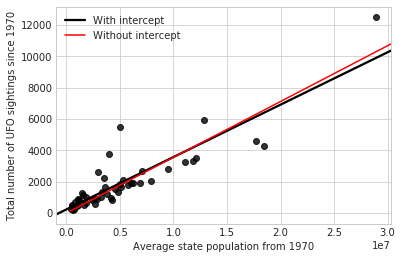

In [106]:
sns.regplot(x='pops', y='sightings', data=df, ci=None, color='black');

# Plotting an OLS without an intercept is buggy so this is a workaround
plt_range = np.array([df.pops.min()*0.8, df.pops.max()*1.2])
plt.plot(plt_range, plt_range*fit2.params[0], 'r-');

plt.xlabel('Average state population from 1970');
plt.ylabel('Total number of UFO sightings since 1970');
plt.legend(['With intercept', 'Without intercept']);


The relationship between population and sightings is not as interesting, however, as analysis of the states which buck the overall trend (ie. those with the largest residuals.) This can be found like so.

In [103]:
# Sorts the residuals by their absolute value and takes the 8 largest.
# Uses the index of these largest values to get the original signed residual
# to see which states have more or fewer sightings than expected for their size.
fit2.resid[fit2.resid.abs().sort_values(ascending=False)[:8].index]

state
WA    3714.185579
AZ    2392.637523
NY   -2261.695290
CA    2238.165050
TX   -1703.412910
OR    1560.101621
FL    1390.227961
CO     993.664814
dtype: float64

These states are candidates for further inspection.

### Number of USAF bases per state vs sightings per thousand people per state

In [35]:
# Fit an ordinary least squares model using base count per state to predict sightings per thousand people
fit2 = sfm.ols('sightings_per_thousand ~ base_count', data=df).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
Dep. Variable:     sightings_per_thousand   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.021
Method:                     Least Squares   F-statistic:                 0.0009804
Date:                    Mon, 27 Nov 2017   Prob (F-statistic):              0.975
Time:                            11:04:48   Log-Likelihood:                 1.6131
No. Observations:                      50   AIC:                            0.7738
Df Residuals:                          48   BIC:                             4.598
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

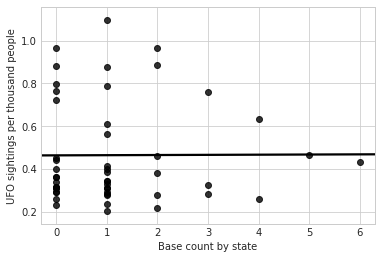

In [105]:
# Plot this fit
sns.regplot(x='base_count', y='sightings_per_thousand', data=df, ci=None, color='black')
plt.xlabel('Base count by state');
plt.ylabel('UFO sightings per thousand people');


The fit and plot both strongly indicate no relationship between the number of USAF bases in a state and the population-normalized number of sightings in that state.

